In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

import time
import numpy as np
import matplotlib.pyplot as plt

tf.enable_eager_execution()
tf.__version__

'1.14.0'

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.fashion_mnist.load_data()

train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

train_data = train_data / 255.
train_data = train_data.reshape(-1, 784)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

valid_data = valid_data / 255.
valid_data = valid_data.reshape(-1, 784)
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)


print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)


(54000, 784) (54000,)
(10000, 784) (10000,)
(6000, 784) (6000,)


In [3]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [5]:
batch_size = 32
max_epochs = 1

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# for test
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

<DatasetV1Adapter shapes: ((?, 784), (?, 10)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((?, 784), (?, 10)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((?, 784), (?, 10)), types: (tf.float32, tf.float32)>


In [6]:
model = tf.keras.models.Sequential()

# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

In [7]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  predictions = model(images[0:1], training=False)
  print("Predictions: ", predictions.numpy())

Predictions:  [[0.14255723 0.0538222  0.20182863 0.03719606 0.12935272 0.1366042
  0.06641537 0.09461855 0.08545718 0.05214781]]


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  25120     
_________________________________________________________________
dense_1 (Dense)              multiple                  330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [9]:
batch_size = 32
max_epochs = 20

# use Adam optimizer 
optimizer = tf.train.AdamOptimizer(1e-4)
loss_object = tf.keras.losses.CategoricalCrossentropy()
acc_object = tf.keras.metrics.CategoricalAccuracy()

# record loss and accuracy for every epoch
mean_loss = tf.keras.metrics.Mean("loss")
mean_accuracy = tf.keras.metrics.Mean("accuracy")

# save loss and accuracy history for plot
loss_history = []
accuracy_history = [(0, 0.0)]

val_loss_history = []
val_accuracy_history = [(0, 0.0)]

In [10]:
def validation(global_step):
  acc_object.reset_states()

  for images, labels in valid_dataset:
    predictions = model(images, training=False)
    loss_value = loss_object(labels, predictions)
    acc_object(labels, predictions)
    
    mean_loss(loss_value)
    mean_accuracy(acc_value)
    
  print("valid loss: {:.4g}, valid accuracy: {:.4g}%".format(mean_loss.result(),
                                                             mean_accuracy.result() * 100))

  val_loss_history.append((global_step.numpy(), mean_loss.result().numpy()))
  val_accuracy_history.append((global_step.numpy(), mean_accuracy.result().numpy()))
  mean_accuracy.reset_states()

In [11]:
print("start training!")
global_step = tf.Variable(0, trainable=False)
num_batches_per_epoch = int(len(train_data) / batch_size)

for epoch in range(max_epochs):
  
  for step, (images, labels) in enumerate(train_dataset):
    start_time = time.time()
    
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss_value = loss_object(labels, predictions)
      acc_value = acc_object(labels, predictions)

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    global_step.assign_add(1)
    
    mean_loss(loss_value)
    mean_accuracy(acc_value)
    loss_history.append((global_step.numpy(), mean_loss.result().numpy()))

    if global_step.numpy() % 10 == 0:
      clear_output(wait=True)
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration) 
      print("epochs: {:.2f}, step: {}, loss: {:.3g}, accuracy: {:.4g}% ({:.2f} examples/sec; {:.4f} sec/batch)".format(
          epochs, global_step.numpy(), loss_value.numpy(), acc_value.numpy()*100, examples_per_sec, duration))
      
  # save mean accuracy for plot
  accuracy_history.append((global_step.numpy(), mean_accuracy.result().numpy()))

  # clear the history
  mean_accuracy.reset_states()
  validation(global_step)

print("training done!")

epochs: 18.69, step: 31550, loss: 0.828, accuracy: 86.85% (3833.48 examples/sec; 0.0083 sec/batch)


KeyboardInterrupt: 

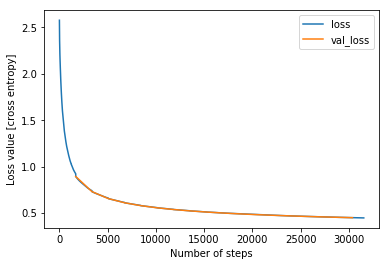

In [12]:
plt.plot(*zip(*loss_history), label='loss')
plt.plot(*zip(*val_loss_history), label='val_loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

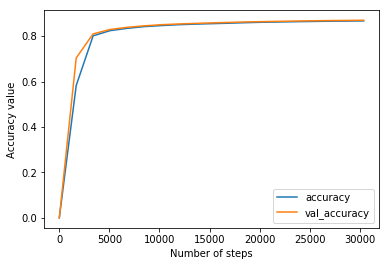

In [13]:
plt.plot(*zip(*accuracy_history), label='accuracy')
plt.plot(*zip(*val_accuracy_history), label='val_accuracy')
plt.xlabel('Number of steps')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

In [14]:
acc_object.reset_states()

for images, labels in test_dataset:
  predictions = model(images, training=False)
  acc_object(labels, predictions)
  
print("test accuracy: {:.4g}%".format(acc_object.result() * 100))

test accuracy: 84.72%


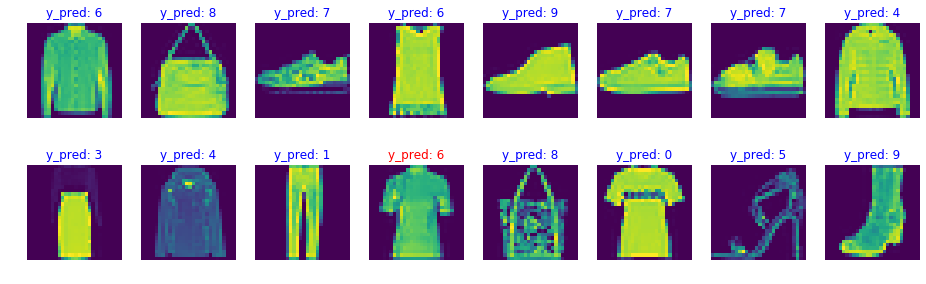

In [15]:
np.random.seed(219)
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')